In [1]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [3]:
image_dir="ca_brai_tumt/"

In [4]:
os.makedirs('C:/Users/Aakarshit Chaurasia/Untitled Folder 2/working/augmented-images', exist_ok = True)
os.makedirs('C:/Users/Aakarshit Chaurasia/Untitled Folder 2/working/augmented-images/yes', exist_ok = True)
os.makedirs('C:/Users/Aakarshit Chaurasia/Untitled Folder 2/working/augmented-images/no', exist_ok = True)

augmented_data_path ='C:/Users/Aakarshit Chaurasia/Untitled Folder 2/working/augmented-images/'

augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_SIZE = (224,224)

In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
dir = os.listdir('C:/Users/Aakarshit Chaurasia/Untitled Folder 2/working/augmented-images/yes') 

if len(dir) == 0: 

    # augment data for the examples with label equal to 'yes' representing tumurous examples
    augment_data(file_dir=image_dir+'yes',n_generated_samples=4, save_to_dir=augmented_data_path+'yes')
    # augment data for the examples with label equal to 'no' rpresenting non-tumurous examples
    augment_data(file_dir=image_dir+'no', n_generated_samples=5, save_to_dir=augmented_data_path+'no')
else:
    print(len(dir))

775


In [7]:
def load_data(dir_list):
    X = []
    y = []
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            # Ensure that every image is resized to IMG_SIZE before appending
            image = cv2.resize(image, IMG_SIZE)
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


"\ndef load_data(dir_list):\n\n    # load all images in a directory\n    X = []\n    y = []\n#     image_width, image_height = image_size\n    \n    for directory in dir_list:\n        for filename in listdir(directory):\n            image = cv2.imread(directory+'/'+filename)\n#             image = crop_brain_contour(image, plot=False)\n#             image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)\n#             # normalize values\n#             image = image / 255.\n#             # convert image to numpy array and append it to X\n            X.append(image)\n            # append a value of 1 to the target array if the image\n            # is in the folder named 'yes', otherwise append 0.\n            if directory[-3:] == 'yes':\n                y.append([1])\n            else:\n                y.append([0])\n                \n    X = np.array(X)\n    y = np.array(y)\n    \n    # Shuffle the data\n    X, y = shuffle(X, y)\n    \n    print(f'N

In [8]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [9]:
X_train, y_train = load_data([augmented_yes, augmented_no])

Number of examples is: 1363
X shape is: (1363, 224, 224, 3)
y shape is: (1363, 1)


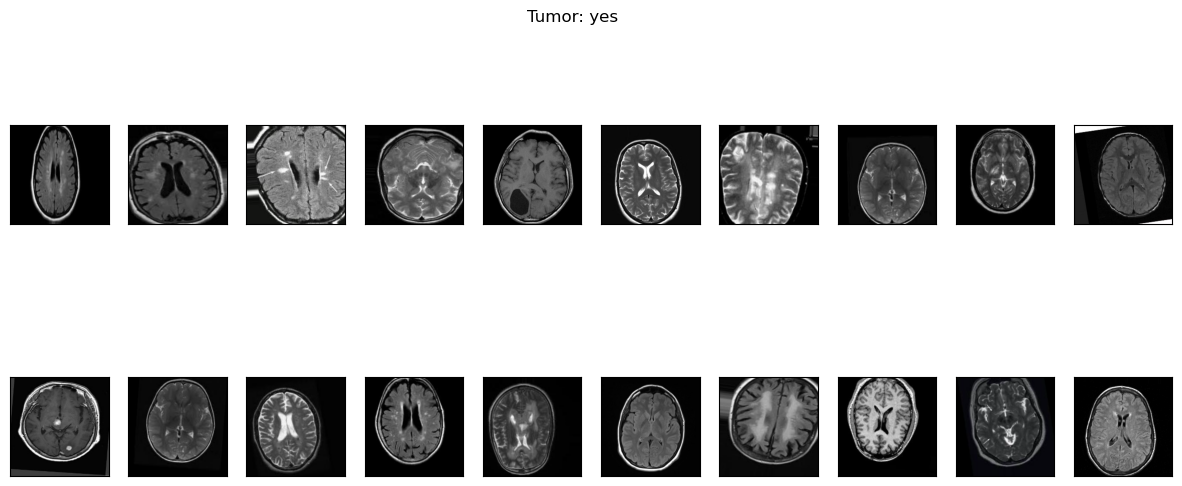

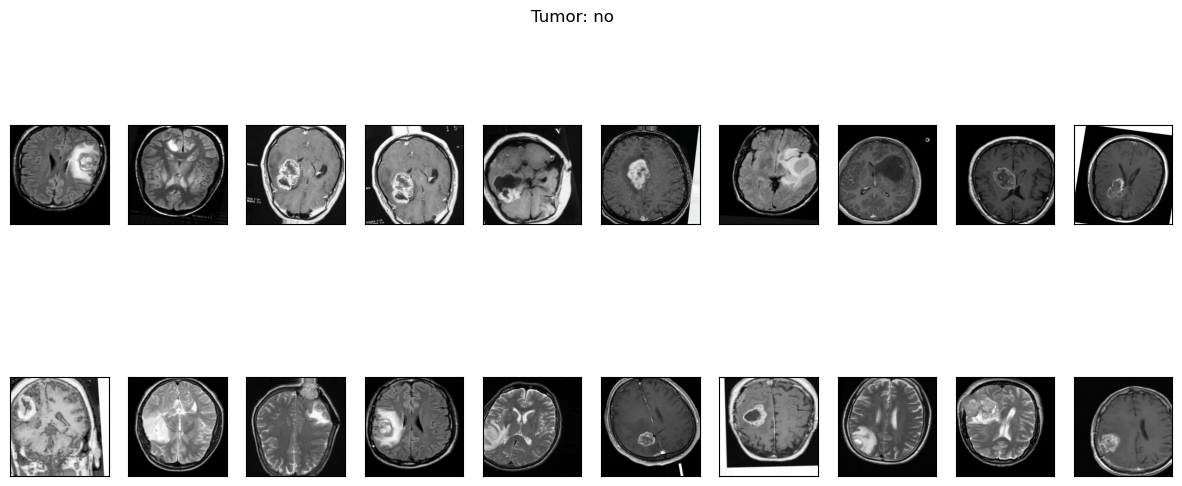

In [10]:
plot_samples(X_train, y_train, ['yes','no'], 20)

## Preprocessing the data

In [11]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, 
                        right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [12]:
img = cv2.imread('ca_brai_tumt/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

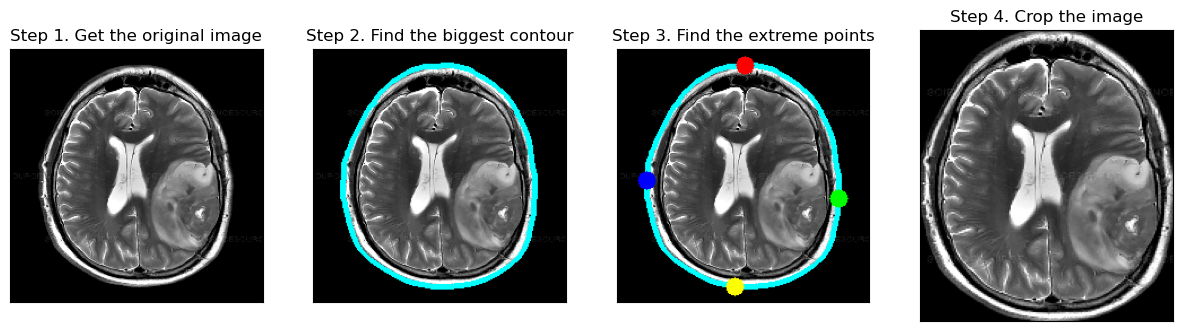

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [14]:
def Croping_Data(train):
    X = []
    
    for img in train:
        image = crop_brain_contour(img, plot=False)
        # Resize the cropped image to have a consistent shape
        image = cv2.resize(image, IMG_SIZE)
        X.append(image)
                
    X = np.array(X)
    
    return X

'def Croping_Data(train):\n\n    # load all images in a directory\n    X = []\n    y = []\n    \n    for img in train:\n        image = crop_brain_contour(img, plot=False)\n        X.append(image)\n                \n    X = np.array(X)\n    \n    return X'

In [15]:
X = Croping_Data(X_train)

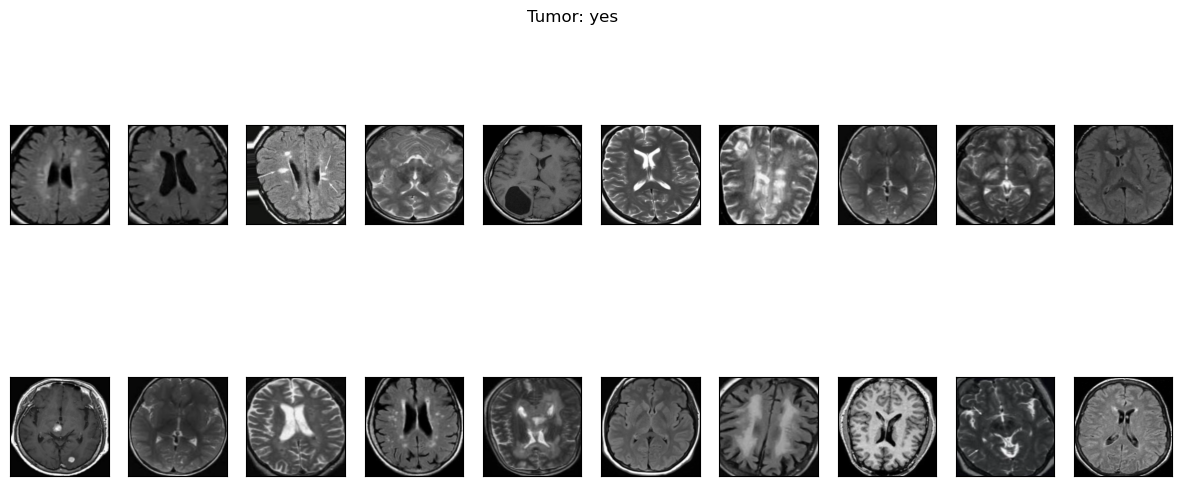

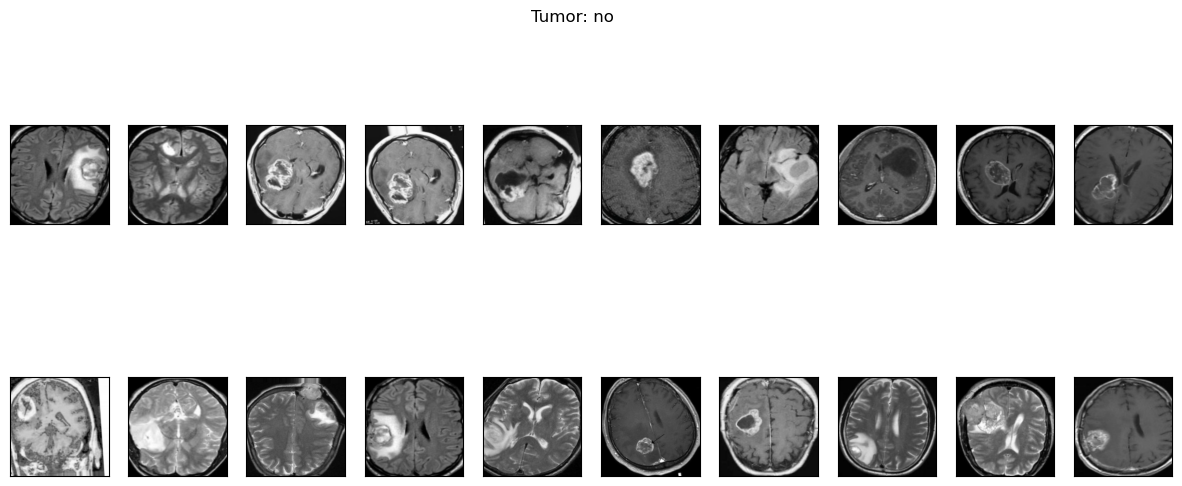

In [16]:
plot_samples(X, y_train, ['yes','no'], 20)

In [17]:
def Resize_Data(train):

    # load all images in a directory
    X = []
    y = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    
    return X

In [18]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X)
y = y_train



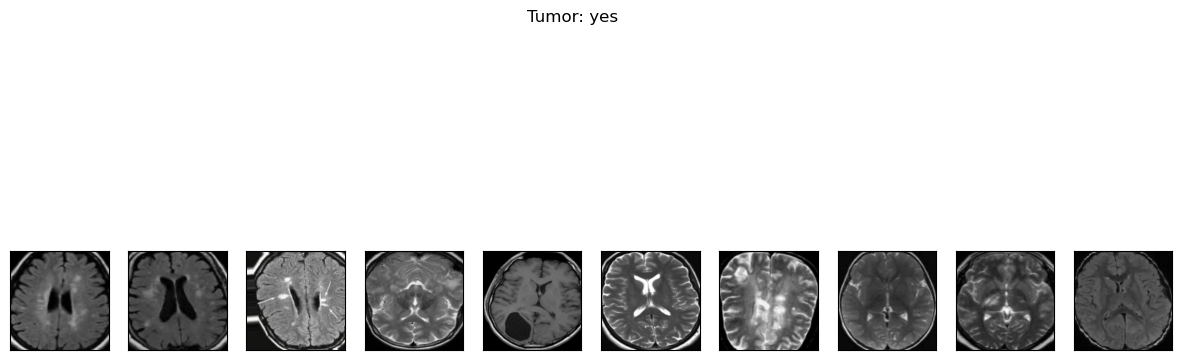

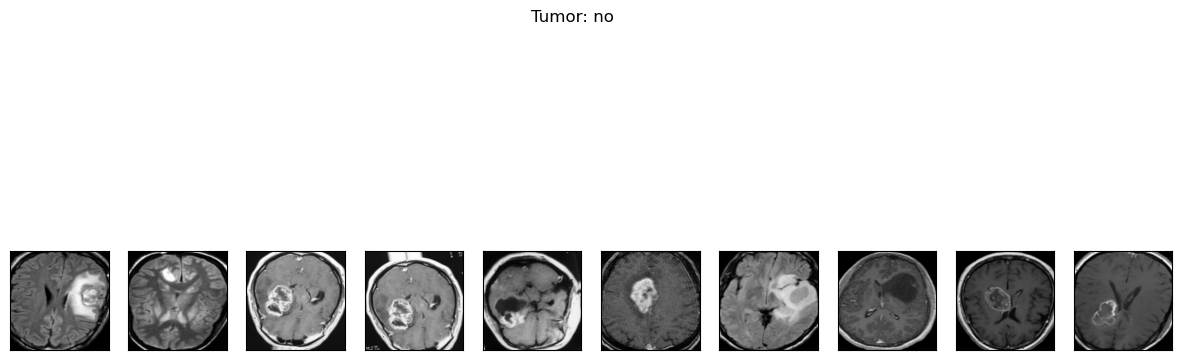

In [19]:
plot_samples(X, y_train, ['yes','no'],10)

## Visualization of data

In [20]:
def split_data(X, y, test_size=0.3):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [22]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 954
number of validation examples = 205
number of test examples = 204


In [23]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

## <a id='build'>4. CNN Modeling</a>

### <a> Model building</a>

In [24]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [25]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                           

### Plotting of aaccuracy

In [26]:
def plot_metrics(history):
    
    train_loss = history['loss']
    train_acc = history['accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(train_acc, label='Training Accuracy')
    plt.title('Loss')
    plt.legend()
    plt.show()

In [28]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
labels = ['yes','no']

### Adding K-fold Cross Validation

In [29]:
from sklearn.model_selection import KFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

num_folds = 5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

vgg16_weight_path = 'ca_brai_tumt/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(weights=vgg16_weight_path,include_top=False, input_shape=IMG_SHAPE)

NUM_CLASSES = 1

for train, test in kfold.split(inputs, targets):
    
    model = Sequential()
    model.add(vgg16_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    model.layers[0].trainable = False

    model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=1e-4),metrics=['accuracy'])
 
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model.fit(inputs[train], targets[train],batch_size=32,epochs=25, verbose=0)
    
    history1 = model.history.history

      # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.24595560133457184; accuracy of 92.67241358757019%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.270775705575943; accuracy of 88.36206793785095%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.27051445841789246; accuracy of 87.93103694915771%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.224910169839859; accuracy of 92.67241358757019%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.2421063333749771; accuracy of 93.50649118423462%
------------------------------------------------------------------------
Score per fold
------------------------------------------

In [30]:
from tensorflow.keras.applications import DenseNet121

In [31]:

num_folds = 5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

densenet_weight_path = 'ca_brai_tumt/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
densenet_model = DenseNet121(weights=densenet_weight_path, include_top=False, input_shape=IMG_SHAPE)

NUM_CLASSES = 1

for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(densenet_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    model.layers[0].trainable = False

    model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=1e-4),metrics=['accuracy'])
 
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model.fit(inputs[train], targets[train],batch_size=32,epochs=25, verbose=0)
    
    history = model.history.history

      # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.14808380603790283; accuracy of 92.67241358757019%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.16396184265613556; accuracy of 95.68965435028076%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.08580374717712402; accuracy of 98.70689511299133%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.12674139440059662; accuracy of 94.3965494632721%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.09205649793148041; accuracy of 95.23809552192688%
------------------------------------------------------------------------
Score per fold
--------------------------------------

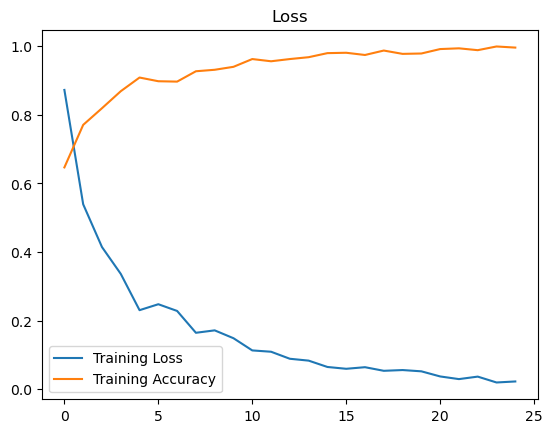

In [32]:
plot_metrics(history)

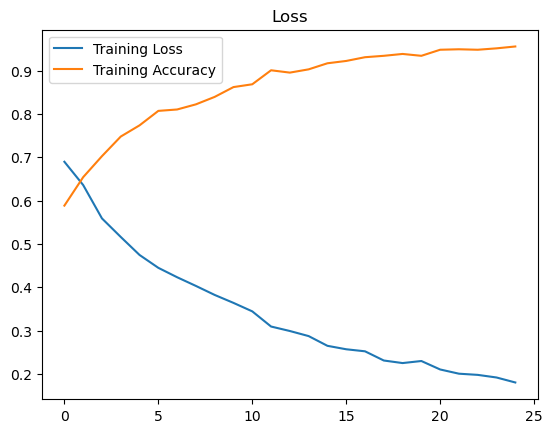

In [33]:
plot_metrics(history1)

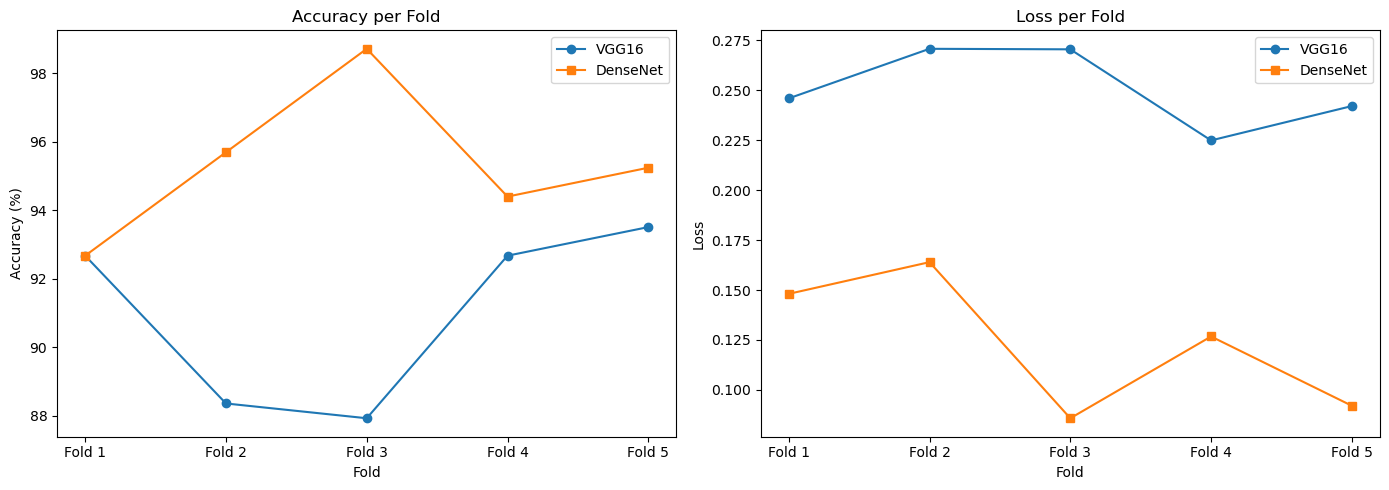

In [58]:
# Plotting
plt.figure(figsize=(14, 5))

accuracy_vgg16 = [92.67241358757019,88.36206793785095,87.93103694915771,92.67241358757019,93.50649118423462]
accuracy_densenet = [92.67241358757019,95.68965435028076,98.70689511299133,94.3965494632721,95.23809552192688]
loss_vgg16 = [0.24595560133457184,0.270775705575943,0.27051445841789246,0.224910169839859,0.2421063333749771]
loss_densenet = [0.14808380603790283,0.16396184265613556,0.08580374717712402,0.12674139440059662,0.09205649793148041]

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(accuracy_vgg16, 'o-', label='VGG16')
plt.plot(accuracy_densenet, 's-', label='DenseNet')
plt.title('Accuracy per Fold')
plt.ylabel('Accuracy (%)')
plt.xlabel('Fold')
plt.xticks(range(5), [f"Fold {i+1}" for i in range(5)])
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss_vgg16, 'o-', label='VGG16')
plt.plot(loss_densenet, 's-', label='DenseNet')
plt.title('Loss per Fold')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.xticks(range(5), [f"Fold {i+1}" for i in range(5)])
plt.legend()

plt.tight_layout()
plt.show()

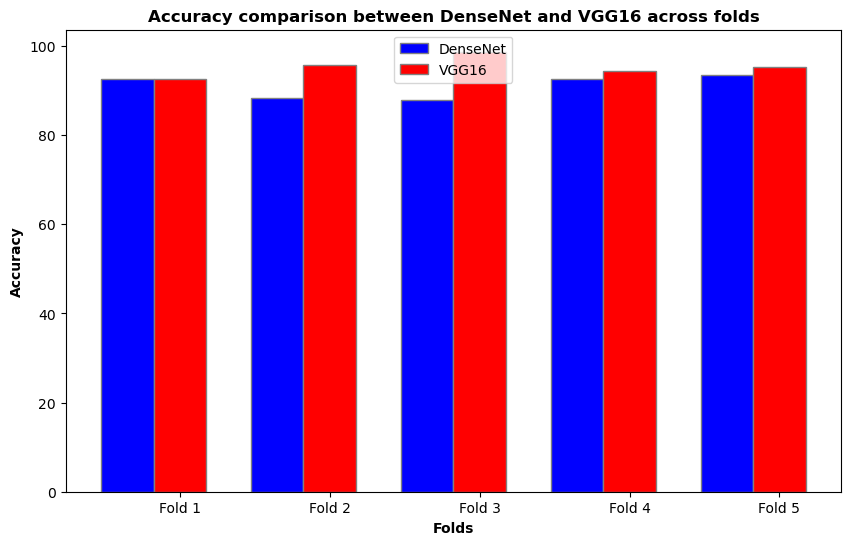

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual values)
acc_per_fold_vgg16 = [92.67241358757019,88.36206793785095,87.93103694915771,92.67241358757019,93.50649118423462]  # Accuracy values for DenseNet model
acc_per_fold_denseNet = [92.67241358757019,95.68965435028076,98.70689511299133,94.3965494632721,95.23809552192688]  # Accuracy values for VGG16 model

num_folds = len(acc_per_fold_vgg16)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars
r1 = np.arange(num_folds)
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10,6))

# Create bars
plt.bar(r1, acc_per_fold_vgg16, width=bar_width, color='blue', edgecolor='grey', label='DenseNet')
plt.bar(r2, acc_per_fold_denseNet, width=bar_width, color='red', edgecolor='grey', label='VGG16')

# Title & Subtitle
plt.title('Accuracy comparison between DenseNet and VGG16 across folds', fontweight='bold')
plt.xlabel('Folds', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')

# X axis
plt.xticks([r + bar_width for r in range(num_folds)], ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])

# Create legend & Show graphic
plt.legend()
plt.show()


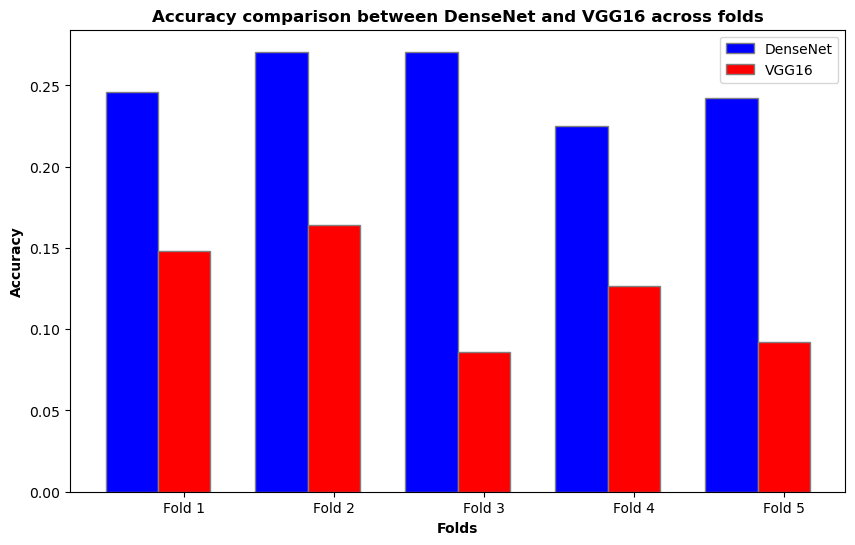

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual values)
loss_per_fold_vgg16 = [0.24595560133457184,0.270775705575943,0.27051445841789246,0.224910169839859,0.2421063333749771]  # Accuracy values for DenseNet model
loss_per_fold_denseNet = [0.14808380603790283,0.16396184265613556,0.08580374717712402,0.12674139440059662,0.09205649793148041]  # Accuracy values for VGG16 model

num_folds = len(loss_per_fold_vgg16)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars
r1 = np.arange(num_folds)
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10,6))

# Create bars
plt.bar(r1, loss_per_fold_vgg16, width=bar_width, color='blue', edgecolor='grey', label='DenseNet')
plt.bar(r2, loss_per_fold_denseNet, width=bar_width, color='red', edgecolor='grey', label='VGG16')

# Title & Subtitle
plt.title('Loss comparison between DenseNet and VGG16 across folds', fontweight='bold')
plt.xlabel('Folds', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')

# X axis
plt.xticks([r + bar_width for r in range(num_folds)], ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])

# Create legend & Show graphic
plt.legend()
plt.show()
